<a href="https://colab.research.google.com/github/pjunecau/test-cassava/blob/main/baseline_efficientNetB4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 5.0MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=3e38a62f7286aa03a799dc2cb167e7e31d04f121fad3c767e85682183f8f19e7
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
import os, cv2, json
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications import EfficientNetB4
from keras.optimizers import Adam

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

In [3]:
# Clear any logs from previous tensorboard runs
!rm -rf ./logs/
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [4]:
from google.colab import files
data_to_load = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c cassava-leaf-disease-classification

100% 5.75G/5.76G [02:03<00:00, 34.2MB/s]
100% 5.76G/5.76G [02:03<00:00, 50.0MB/s]


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('cassava-leaf-disease-classification.zip', 'r')
zip_ref.extractall('cassava-leaf-disease-classification')
zip_ref.close()

In [8]:
WORK_DIR = os.getcwd()+'/cassava-leaf-disease-classification'
os.listdir(WORK_DIR)

['test_tfrecords',
 'train_tfrecords',
 'test_images',
 'train.csv',
 'label_num_to_disease_map.json',
 'sample_submission.csv',
 'train_images']

In [9]:
print('Train images: %d' %len(os.listdir(
    os.path.join(WORK_DIR, "train_images"))))

Train images: 21397


In [10]:
with open(os.path.join(WORK_DIR, "label_num_to_disease_map.json")) as file:
    print(json.dumps(json.loads(file.read()), indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [11]:
train_labels = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
train_labels.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


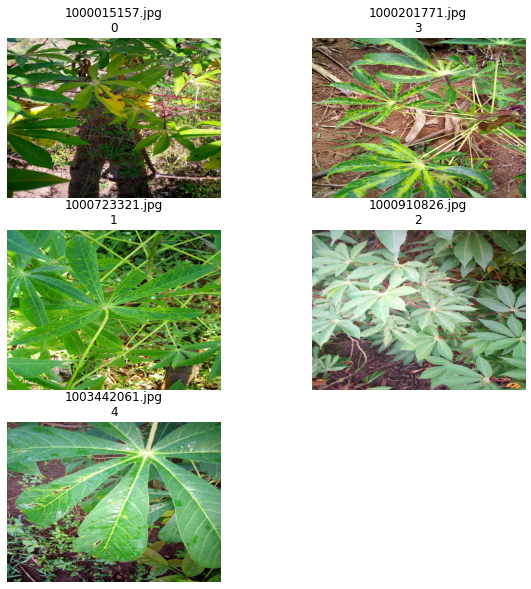

In [12]:
# Image sample from 5 different classes
sample_images = ['1000015157.jpg','1000723321.jpg','1000910826.jpg','1000201771.jpg','1003442061.jpg']
sample_images_df = train_labels[train_labels.image_id.isin(sample_images)]
plt.figure(figsize=(10,10))
for ind, (image_id, label) in enumerate(zip(sample_images_df.image_id, sample_images_df.label)):
    plt.subplot(3, 2, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.title('{}\n{}'.format(image_id,label))
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

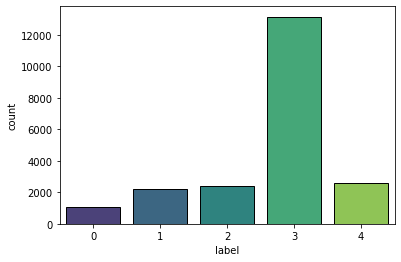

In [13]:
sns.countplot(train_labels.label, edgecolor = 'black',
              palette = sns.color_palette("viridis", 5))
plt.show()

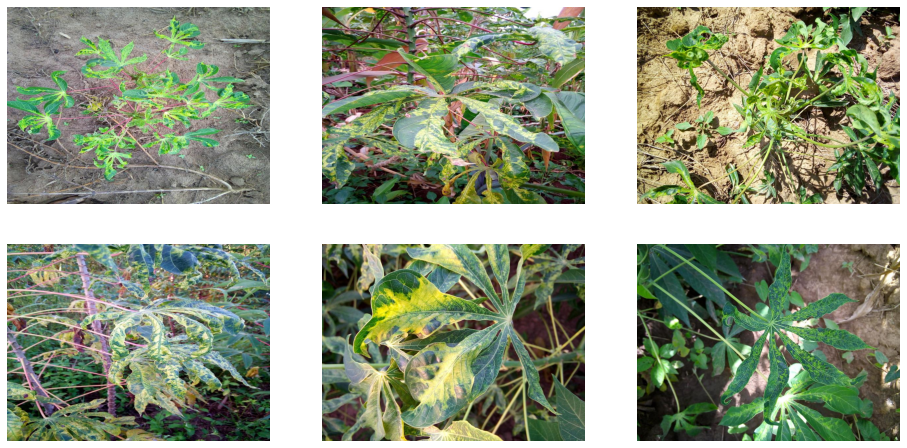

In [14]:
sample = train_labels[train_labels.label == 3].sample(6)
plt.figure(figsize=(16, 8))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(2, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

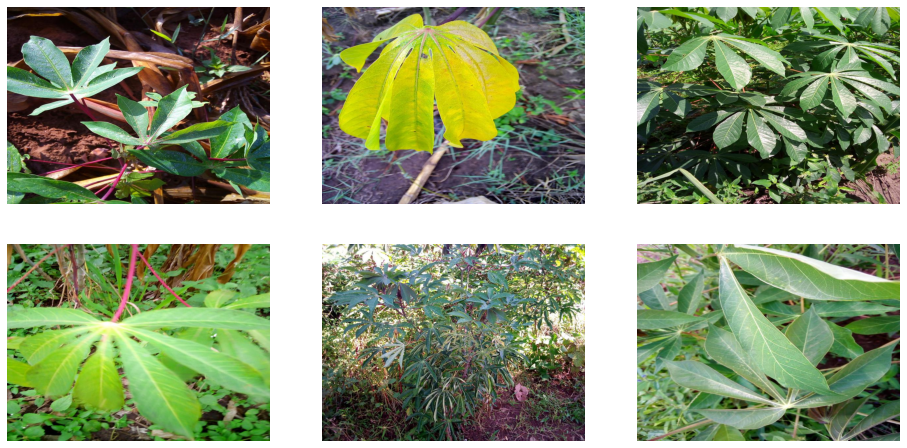

In [15]:
sample = train_labels[train_labels.label == 4].sample(6)
plt.figure(figsize=(16, 8))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(2, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

In [16]:
y_pred = [3] * len(train_labels.label)
print('The baseline accuracy: %.3f' 
      %accuracy_score(y_pred, train_labels.label,normalize=True))

The baseline accuracy: 0.615


In [17]:
BATCH_SIZE = 16
STEPS_PER_EPOCH = len(train_labels)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_labels)*0.2 / BATCH_SIZE
EPOCHS = 10
TARGET_SIZE = 299

In [18]:
train_labels.label = train_labels.label.astype('str')
#validation_split parameter allows for us to split 20% of the data into the validation set automatically without train test split
#Then you can allow .flow_from_dataframe to breakout the train versus validation in the data
train_generator = ImageDataGenerator(validation_split = 0.2,
                                     preprocessing_function = None,
                                     zoom_range = 0.2,
                                     cval = 0.2,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     rotation_range = 5,
                                     fill_mode = 'constant',
                                     shear_range = 0.2,
                                     height_shift_range = 0.2,
                                     width_shift_range = 0.2) \
    .flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

validation_generator = ImageDataGenerator(validation_split = 0.2) \
    .flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [19]:
def create_model():
    model = models.Sequential()

    model.add(EfficientNetB4(include_top = False, weights = 'imagenet',
                             input_shape = (TARGET_SIZE, TARGET_SIZE, 3)))
    
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(5, activation = "softmax"))

    model.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])
    return model

In [20]:
model = create_model()

71688192/71686520 [==============================] - 1s 0us/step


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 10, 10, 1792)      17673823  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 8965      
Total params: 17,682,788
Trainable params: 17,557,581
Non-trainable params: 125,207
_________________________________________________________________


In [22]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model_save = ModelCheckpoint('./best_baseline_model.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)

In [23]:
history = model.fit(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [tensorboard_callback,model_save, early_stop, reduce_lr]
    )

Epoch 1/10
1069/1069 [==============================] - 692s 604ms/step - loss: 0.7584 - acc: 0.7319 - val_loss: 0.5329 - val_acc: 0.8126

Epoch 00001: val_loss improved from inf to 0.53286, saving model to ./best_baseline_model.h5
Epoch 2/10
1069/1069 [==============================] - 616s 575ms/step - loss: 0.5452 - acc: 0.8135 - val_loss: 0.5922 - val_acc: 0.8149

Epoch 00002: val_loss did not improve from 0.53286
Epoch 3/10
1069/1069 [==============================] - 618s 578ms/step - loss: 0.4643 - acc: 0.8411 - val_loss: 0.9482 - val_acc: 0.6602

Epoch 00003: val_loss did not improve from 0.53286

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/10
1069/1069 [==============================] - 620s 580ms/step - loss: 0.4040 - acc: 0.8611 - val_loss: 0.3899 - val_acc: 0.8768

Epoch 00004: val_loss improved from 0.53286 to 0.38991, saving model to ./best_baseline_model.h5
Epoch 5/10
1069/1069 [==============================] - 616s 576ms/step

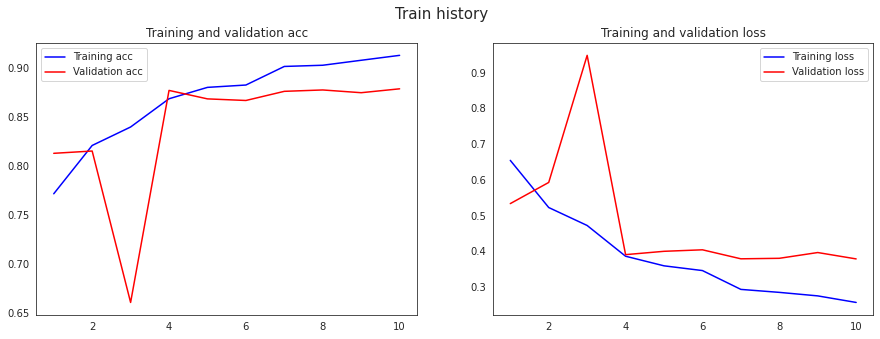

In [29]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, accuracy, "b", label = "Training acc")
ax1.plot(epochs, val_accuracy, "r", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "b", label = "Training loss")
ax2.plot(epochs, val_loss, "r", label = "Validation loss")
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()